In [6]:
from PIL import Image
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
 
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
 
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
 
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [4]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
 
    return model

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
 
 
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
 
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, 
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, 
    collate_fn=utils.collate_fn)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
 
# our dataset has two classes only - background and person
num_classes = 2
 
# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)
 
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [12]:
# let's train it for 10 epochs
num_epochs = 10
 
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

<class 'tuple'>
Epoch: [0]  [ 0/60]  eta: 0:08:26  lr: 0.000090  loss: 2.7526 (2.7526)  loss_classifier: 0.7461 (0.7461)  loss_box_reg: 0.3279 (0.3279)  loss_mask: 1.6621 (1.6621)  loss_objectness: 0.0136 (0.0136)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 8.4386  data: 0.0838  max mem: 2334
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [0]  [10/60]  eta: 0:01:15  lr: 0.000936  loss: 1.3767 (1.7170)  loss_classifier: 0.5190 (0.4841)  loss_box_reg: 0.3119 (0.2968)  loss_mask: 0.6859 (0.9139)  loss_objectness: 0.0136 (0.0174)  loss_rpn_box_reg: 0.0044 (0.0047)  time: 1.5139  data: 0.0434  max mem: 3490
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [0]  [20/60]  eta: 0:00:43  lr: 0.001783  loss: 0.9409 (1.2265)  loss_classifier: 0.2347 (0.3346)  loss_b

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:13  model_time: 0.2663 (0.2663)  evaluator_time: 0.0020 (0.0020)  time: 0.2763  data: 0.0070  max mem: 3532
Test:  [49/50]  eta: 0:00:00  model_time: 0.1207 (0.1248)  evaluator_time: 0.0030 (0.0052)  time: 0.1421  data: 0.0138  max mem: 3532
Test: Total time: 0:00:07 (0.1456 s / it)
Averaged stats: model_time: 0.1207 (0.1248)  evaluator_time: 0.0030 (0.0052)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.944
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [3]  [10/60]  eta: 0:00:32  lr: 0.000500  loss: 0.2070 (0.2057)  loss_classifier: 0.0235 (0.0280)  loss_box_reg: 0.0440 (0.0487)  loss_mask: 0.1134 (0.1241)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0022 (0.0036)  time: 0.6456  data: 0.0297  max mem: 3532
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [3]  [20/60]  eta: 0:00:25  lr: 0.000500  loss: 0.1840 (0.1926)  loss_classifier: 0.0235 (0.0252)  loss_box_reg: 0.0430 (0.0429)  loss_mask: 0.1137 (0.1199)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0020 (0.0033)  time: 0.6405  data: 0.0292  max mem: 3532
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


Test:  [49/50]  eta: 0:00:00  model_time: 0.1227 (0.1258)  evaluator_time: 0.0030 (0.0047)  time: 0.1440  data: 0.0133  max mem: 3532
Test: Total time: 0:00:07 (0.1464 s / it)
Averaged stats: model_time: 0.1227 (0.1258)  evaluator_time: 0.0030 (0.0047)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.830
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [6]  [20/60]  eta: 0:00:26  lr: 0.000050  loss: 0.1652 (0.1718)  loss_classifier: 0.0240 (0.0259)  loss_box_reg: 0.0325 (0.0349)  loss_mask: 0.1050 (0.1083)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0019 (0.0020)  time: 0.6538  data: 0.0291  max mem: 3532
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [6]  [30/60]  eta: 0:00:19  lr: 0.000050  loss: 0.1666 (0.1726)  loss_classifier: 0.0220 (0.0254)  loss_box_reg: 0.0317 (0.0351)  loss_mask: 0.1083 (0.1089)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 0.6403  data: 0.0278  max mem: 3532
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


Epoch: [8]  [ 0/60]  eta: 0:00:33  lr: 0.000050  loss: 0.1508 (0.1508)  loss_classifier: 0.0269 (0.0269)  loss_box_reg: 0.0194 (0.0194)  loss_mask: 0.1033 (0.1033)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 0.5615  data: 0.0299  max mem: 3532
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [8]  [10/60]  eta: 0:00:31  lr: 0.000050  loss: 0.1733 (0.1899)  loss_classifier: 0.0271 (0.0291)  loss_box_reg: 0.0305 (0.0410)  loss_mask: 0.1067 (0.1162)  loss_objectness: 0.0002 (0.0010)  loss_rpn_box_reg: 0.0022 (0.0026)  time: 0.6399  data: 0.0325  max mem: 3532
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
Epoch: [8]  [20/60]  eta: 0:00:25  lr: 0.000050  loss: 0.1599 (0.1922)  loss_classifier: 0.0260 (0.0284)  loss_box_reg: 0.0305 (

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:17  model_time: 0.3361 (0.3361)  evaluator_time: 0.0020 (0.0020)  time: 0.3460  data: 0.0070  max mem: 3532
Test:  [49/50]  eta: 0:00:00  model_time: 0.1267 (0.1324)  evaluator_time: 0.0030 (0.0048)  time: 0.1479  data: 0.0149  max mem: 3532
Test: Total time: 0:00:07 (0.1545 s / it)
Averaged stats: model_time: 0.1267 (0.1324)  evaluator_time: 0.0030 (0.0048)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.838
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.928
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

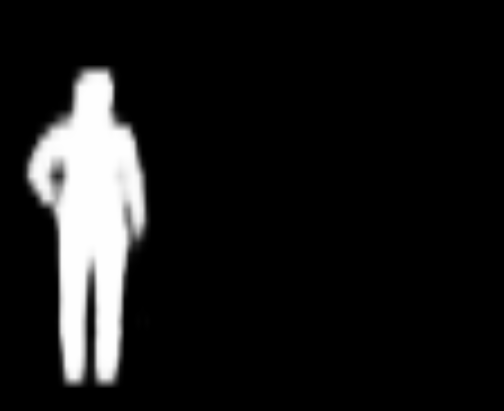

In [52]:
# pick one image from the test set
img, _ = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
 
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())


In [53]:
from PIL import ImageDraw

print('predictions', prediction)
bbox = []
for i in range(len(prediction[0]['boxes'])):
    bbox.append(prediction[0]['boxes'].detach().cpu().numpy()[i])
# bbox_1 = prediction[0]['boxes'].detach().cpu().numpy()[0]
# bbox_2 = prediction[0]['boxes'].detach().cpu().numpy()[1]
# bbox_3 = prediction[0]['boxes'].detach().cpu().numpy()[2]
# bbox_4 = prediction[0]['boxes'].detach().cpu().numpy()[3]


pred_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(pred_img)
for i in range(len(prediction[0]['boxes'])):
    draw.rectangle(((bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3])), outline="red")
# draw.rectangle(((bbox_1[0], bbox_1[1]), (bbox_1[2], bbox_1[3])), outline="red")
# draw.rectangle(((bbox_2[0], bbox_2[1]), (bbox_2[2], bbox_2[3])), outline="red")
# draw.rectangle(((bbox_3[0], bbox_3[1]), (bbox_3[2], bbox_3[3])), outline="red")
# draw.rectangle(((bbox_4[0], bbox_4[1]), (bbox_4[2], bbox_4[3])), outline="red")
pred_img.show()

predictions [{'boxes': tensor([[ 24.0356,  70.3574, 149.0498, 382.0404],
        [339.4797,  87.8962, 426.4829, 349.3356],
        [232.4799,  79.4850, 311.8842, 390.7229],
        [146.9669,  77.9523, 247.6563, 382.9934],
        [ 12.8370,  60.7424,  62.1635, 181.0829]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.9979, 0.9967, 0.9957, 0.9464], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ...,